<h1 align="center">Complex Analysis of Restaurant Reviews
<h2 align="center">Project of Group 56 - Text Mining @ Vrije Universiteit Amsterdam

Analyzing textual data for sentiment, entity recognition, and thematic content has become crucial in the quickly developing field of natural language processing in order to derive useful insights. This research project, takes a comprehensive journey through the analysis of restaurant reviews using Natural Language Processing (NLP) methods. In this notebook, three Natural Language Processing (NLP) techniques will be applied: Sentiment Analysis, Named Entity Recognition and Classification (NERC) and Topic Analysis. The goal of sentiment analysis is to classify text as positive, negative or neutral. NERC identifies important entities and classifies them, such as Persons, Location or Date and Time. Topic Analysis can categorize text entries - in the case of LDA - into pre-determined topics.

### **Importing the dataset**

The initial phase of our research project involved looking for a dataset, and preparing that to our NLP analysis. We obtained the "Restaurant Customer Reviews" dataset from Kaggle (https://www.kaggle.com/datasets/vigneshwarsofficial/reviews). This consists of 1000 textual reviews from guests of a single restaurant. Each review was pre-labeled with binary sentiment values - 1 representing positive feedback and 0 stating negative opinions. This structured dataset served as the foundational corpus for our analysis.

In [1]:
import pandas as pd

data = pd.read_csv('Restaurant_Reviews.tsv', sep='\t')
print(data.iloc[0:10])

                                              Review  Liked
0                           Wow... Loved this place.      1
1                                 Crust is not good.      0
2          Not tasty and the texture was just nasty.      0
3  Stopped by during the late May bank holiday of...      1
4  The selection on the menu was great and so wer...      1
5     Now I am getting angry and I want my damn pho.      0
6              Honeslty it didn't taste THAT fresh.)      0
7  The potatoes were like rubber and you could te...      0
8                          The fries were great too.      1
9                                     A great touch.      1


### **Preprocessing**

The dataset underwent a number of preprocessing processes, which were essential for improving the precision of our NLP models. The binary sentiment labels were converted into two more comprehensible sting entries — "positive" and "negative" — to start the preprocessing pipeline. We utilized lemmatization to normalize the textual data to handle the variability and complexity of language. Using a WordNetLemmatizer and the Natural Language Toolkit (nltk), every word in the reviews was reduced to its lemma, also known as their basic form. Lemmatization was combined with the removal of unnecessary punctuation, such as commas and periods, and a filtering phase was used to remove any reviews that were empty or irrelevant, guaranteeing that the dataset had no null values. These preparation activities were essential to build a strong basis for the more complex analysis that came after.

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Converting numerical values into text labels
data['Liked'] = data['Liked'].replace({1: 'positive', 0: 'negative'})

# Making all entries lowercase
#data['Review'] = data['Review'].str.lower()

# Applying lemmatization
def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    word_list = word_tokenize(sentence)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

data['Review'] = data['Review'].apply(lambda x: lemmatize_sentence(x))

# Removing periods
data['Review'] = data['Review'].str.replace('.', '', regex=False)
data['Review'] = data['Review'].str.replace(',', '', regex=False)

# Remove NaN values
data = data[data['Review'].notna() & (data['Review'] != '')]

print(data.iloc[0:10])

                                              Review     Liked
0                             Wow  Loved this place   positive
1                                 Crust is not good   negative
2           Not tasty and the texture wa just nasty   negative
3  Stopped by during the late May bank holiday of...  positive
4  The selection on the menu wa great and so were...  positive
5     Now I am getting angry and I want my damn pho   negative
6            Honeslty it did n't taste THAT fresh  )  negative
7  The potato were like rubber and you could tell...  negative
8                            The fry were great too   positive
9                                     A great touch   positive


# **Sentiment Analysis - VADER**

The Valence Aware Dictionary and sEntiment Reasoner (VADER) - a lexicon and rule-based sentiment analysis tool - was utilized in our study to conduct sentiment analysis. By computing the valence ratings of each text input, VADER is designed to analyze text sentiment and determine whether it is positive, negative, or neutral. This method was selected in particular because it is good at managing slang, emoticons, and casual language—all of which are common in restaurant reviews.

VADER learned how to predict sentiment based on the Restaurant Review's "Liked" column. This indicated whether the review is positive or negative. Then predictions will be made with the help of this model, and those labels will be compared to the Gold Set, avaliable with the Restaurant Review dataset.

With VADER there is an option to filter for Part-Of-Speech segments. Tests were carried out to assess how VADER's performance was affected by these selective examination of POS segments, however, these tests did not produce appreciable differences in the result, indicating the robustness of VADER across different textual contexts.

In [3]:
def run_vader(textual_unit, 
              lemmatize=False, 
              parts_of_speech_to_consider=None,
              verbose=0):
    """
    Run VADER on a sentence from spacy
    
    :param str textual unit: a textual unit, e.g., sentence, sentences (one string)
    (by looping over doc.sents)
    :param bool lemmatize: If True, provide lemmas to VADER instead of words
    :param set parts_of_speech_to_consider:
    -None or empty set: all parts of speech are provided
    -non-empty set: only these parts of speech are considered.
    :param int verbose: if set to 1, information is printed
    about input and output
    
    :rtype: dict
    :return: vader output dict
    """
    doc = nlp(textual_unit)
        
    input_to_vader = []

    for sent in doc.sents:
        for token in sent:

            to_add = token.text

            if lemmatize:
                to_add = token.lemma_

                if to_add == '-PRON-': 
                    to_add = token.text

            if parts_of_speech_to_consider:
                if token.pos_ in parts_of_speech_to_consider:
                    input_to_vader.append(to_add) 
            else:
                input_to_vader.append(to_add)

    scores = vader_model.polarity_scores(' '.join(input_to_vader))
    
    if verbose >= 1:
        print()
        print('INPUT SENTENCE', sent)
        print('INPUT TO VADER', input_to_vader)
        print('VADER OUTPUT', scores)

    return scores

def vader_output_to_label(vader_output):
    """
    map vader output e.g.,
    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4215}
    to one of the following values:
    a) positive float -> 'positive'
    b) 0.0 -> 'neutral'
    c) negative float -> 'negative'
    
    :param dict vader_output: output dict from vader
    
    :rtype: str
    :return: 'negative' | 'neutral' | 'positive'
    """
    compound = vader_output['compound']
    
    if compound < 0:
        return 'negative'
    elif compound == 0.0:
        return 'neutral'
    elif compound > 0.0:
        return 'positive'
    
assert vader_output_to_label( {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.0}) == 'neutral' #neutral
assert vader_output_to_label( {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.01}) == 'positive' #positive
assert vader_output_to_label( {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': -0.01}) == 'negative' #negative

In [4]:
from sklearn.metrics import classification_report
import spacy
nlp = spacy.load("en_core_web_sm")
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader_model = SentimentIntensityAnalyzer()

reviews = []
all_vader_output = []
gold = []

pos = set()

for index, row in data.iterrows():
    the_review = row['Review']
    vader_output = run_vader(the_review,
                             lemmatize=False,
                             verbose=0)
    vader_label = vader_output_to_label(vader_output)
    
    reviews.append(the_review)
    all_vader_output.append(vader_label)
    gold.append(row['Liked'])
    

print(classification_report(gold, all_vader_output))

              precision    recall  f1-score   support

    negative       0.94      0.49      0.64       500
     neutral       0.00      0.00      0.00         0
    positive       0.81      0.82      0.82       500

    accuracy                           0.66      1000
   macro avg       0.58      0.44      0.49      1000
weighted avg       0.87      0.66      0.73      1000



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

While the model is very effective at classifying a review as negative, it only detects a small percentage of all negative reviews. This is equivalent to a high precision but moderate recall for negative sentiments. On the other hand, the model exhibits a great balance between recall and precision for positive sentiments, indicating a more dependable performance in identifying and categorizing positive reviews.

### **Manual Analysis of Results**

We manually examined a subset of the predicted labels and compared them to the original "Liked" labels. As seen above, VADER classifies text entries into three categories - positive, negative and neutral -, while the database only includes two of those categories - the two opposites, positive and negative. Further research could include rerunning the test with a dataset consisting of such three categories. These differences can be observed in the second code block below.

In [5]:
for i, tweet in enumerate(reviews[:10]):
        print(gold[i], "-", all_vader_output[i], "______", tweet)

positive - positive ______ Wow  Loved this place 
negative - negative ______ Crust is not good 
negative - negative ______ Not tasty and the texture wa just nasty 
positive - positive ______ Stopped by during the late May bank holiday off Rick Steve recommendation and loved it 
positive - positive ______ The selection on the menu wa great and so were the price 
negative - negative ______ Now I am getting angry and I want my damn pho 
negative - negative ______ Honeslty it did n't taste THAT fresh  )
negative - positive ______ The potato were like rubber and you could tell they had been made up ahead of time being kept under a warmer 
positive - positive ______ The fry were great too 
positive - positive ______ A great touch 


In [6]:
for i, tweet in enumerate(reviews):
    if gold[i] != all_vader_output[i]:
        if all_vader_output[i] == "neutral":
            print("GOLD:", gold[i], "VADER:", all_vader_output[i], "\n", tweet)

GOLD: positive VADER: neutral 
 Service wa very prompt 
GOLD: negative VADER: neutral 
 Would not go back 
GOLD: positive VADER: neutral 
 I tried the Cape Cod ravoli  chicken  with cranberry  mmmm !
GOLD: negative VADER: neutral 
 Waitress wa a little slow in service 
GOLD: positive VADER: neutral 
 So they performed 
GOLD: negative VADER: neutral 
 - They never brought a salad we asked for 
GOLD: positive VADER: neutral 
 The only redeeming quality of the restaurant wa that it wa very inexpensive 
GOLD: positive VADER: neutral 
 The shrimp tender and moist 
GOLD: positive VADER: neutral 
 He came running after u when he realized my husband had left his sunglass on the table 
GOLD: positive VADER: neutral 
 This place receives star for their APPETIZERS ! ! !
GOLD: negative VADER: neutral 
 We got the food and apparently they have never heard of salt and the batter on the fish wa chewy 
GOLD: positive VADER: neutral 
 The deal included 5 tasting and 2 drink  and Jeff went above and bey

### **Proportion of Results**

The poster corresponding to this project includes a figure, showcasing the proportion of each sentiment label. This is calculated in this step.

In [7]:
gold_pos = 0
gold_neg = 0
pred_pos = 0
pred_neg = 0
pred_neu = 0

for i, tweet in enumerate(reviews):
    if gold[i] == "positive":
        gold_pos += 1
    else:
        gold_neg += 1
    if all_vader_output[i] == "positive":
        pred_pos +=1
    elif all_vader_output[i] == "negative":
        pred_neg += 1
    else:
        pred_neu += 1

print("pos:",pred_pos,"neg:",pred_neg,"neu:",pred_neu)

pos: 510 neg: 262 neu: 228


### **Evaluating on Baseline Dataset**

An additional analysis has been run to asses VADER's performance. This was performed on the baseline dataset provided by the teaching staff of the Text Mining course. This baseline dataset includes sentences with labeled sentiments, aiming to provide a baseline to asess the trained model's performance and transferability.

In [8]:
import pandas as pd
test_data = pd.read_csv('sentiment-topic-test.tsv', sep='\t')

predictions = []
for tweet in test_data['text']:
    vader_output = run_vader(tweet, lemmatize=True, verbose=False)
    predictions.append(vader_output_to_label(vader_output))

print(classification_report(test_data['sentiment'], predictions, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         4
     neutral       0.33      0.33      0.33         3
    positive       0.20      0.33      0.25         3

    accuracy                           0.20        10
   macro avg       0.18      0.22      0.19        10
weighted avg       0.16      0.20      0.17        10



The model is unable to correctly identify any negative instances, suggesting a significant obsticle in classifying negative sentiments. However, it did have limited capability in recognizing positive and neutral sentiments. Despite this, overall accuracy is still poor, indicating poor transferability of the VADER model trained on the Restaurant Review dataset.

# **Sentiment Analysis - RoBERTa**

Expanding upon basic sentiment analysis carried out with VADER, our study explored the potential of advanced deep learning models, including the HuggingFace transformer model RoBERTa (Robustly Optimized BERT Pretraining Approach). The choice was motivated by RoBERTa's established ability to understand natural language and its adaptability in handling unique classification tasks, allowing a more detailed analysis of sentiment in our dataset. The flexibility of RoBERTa was especially helpful in enabling a binary sentiment classification technique that matched the positive and negative labels present in our corpus.

To guarantee reliable model evaluation and optimization, the dataset was divided into training, testing, and development sets. In order to improve performance, we carefully set up the model's parameters. For example, we used early stopping conditions to avoid overfitting and adjusted learning rates for best convergence.

The model's loss metrics were closely monitored during training, providing valuable information regarding the process of learning and the need for model adjustments. In the assessment phase that followed, predictions were made on the test set and compared to the true labels in order to evaluate the model's accuracy and performance. 

In [9]:
import pandas as pd
import numpy as np
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/Users/markbartos/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Converting sentiment labels back to numerical format
data['labels'] = data['Liked'].map({'negative': 0, 'positive': 1})

# Split the data into training and testing sets
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data[['labels']])
train, dev = train_test_split(train, test_size=0.1, random_state=0, stratify=train[['labels']])

# Model configuration
model_args = ClassificationArgs()
model_args.overwrite_output_dir=True
model_args.evaluate_during_training=True
model_args.num_train_epochs=2
model_args.train_batch_size=32
model_args.learning_rate=4e-6
model_args.max_seq_length=256
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_patience=2
model_args.evaluate_during_training_steps=50

model = ClassificationModel('roberta', 'roberta-base', num_labels=2, args=model_args, use_cuda=False)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Training the model
_, history = model.train_model(train[['Review', 'labels']], eval_df=dev[['Review', 'labels']])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/simpletransformers/classification/classification_model.py:608: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2it [00:05,  2.68s/it]                       


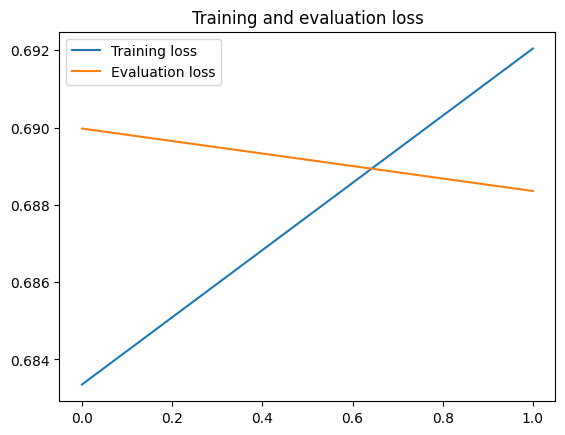

In [14]:
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend()
plt.show()

In [15]:
sentences = test['Review'].tolist()

# Get predictions
predictions, raw_outputs = model.predict(sentences)

predicted_labels = ['positive' if prediction == 1 else 'negative' for prediction in predictions]
for sentence, prediction in zip(sentences, predicted_labels):
    print(f"Sentence: {sentence}\nPredicted Sentiment: {prediction}\n")

0it [00:00, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
1it [00:04,  4.39s/it]
100%|██████████| 2/2 [00:11<00:00,  5.87s/it]

Sentence: Awesome selection of beer 
Predicted Sentiment: positive

Sentence: Not much flavor to them  and very poorly constructed 
Predicted Sentiment: positive

Sentence: Worse of all  he humiliated his worker right in front of me  Bunch of horrible name calling 
Predicted Sentiment: positive

Sentence: Host staff were  for lack of a better word  BITCHES !
Predicted Sentiment: positive

Sentence: Great brunch spot 
Predicted Sentiment: positive

Sentence: The service wa great  even the manager came and helped with our table 
Predicted Sentiment: positive

Sentence: Of all the dish  the salmon wa the best  but all were great 
Predicted Sentiment: positive

Sentence: Service is quick and even `` to go '' order are just like we like it !
Predicted Sentiment: positive

Sentence: I 've never been more insulted or felt disrespected 
Predicted Sentiment: positive

Sentence: Hard to judge whether these side were good because we were grossed out by the melted styrofoam and did n't want to eat

In [16]:
from sklearn.metrics import classification_report
true_labels = test['labels'].tolist()
print(classification_report(true_labels, predictions, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       1.00      0.01      0.02       100
    positive       0.50      1.00      0.67       100

    accuracy                           0.51       200
   macro avg       0.75      0.51      0.34       200
weighted avg       0.75      0.51      0.34       200



### **Evaluating on Baseline Dataset**

In a similiar manner as before, an additional analysis has been run to asses RoBERTa's performance. This was performed on the baseline dataset provided by the teaching staff of the Text Mining course. This baseline dataset includes sentences with labeled sentiments, aiming to provide a baseline to asess the trained model's performance and transferability.

# **NERC**
We analyze Named Entity Recognition and Classification (NERC) in this section by pre-training a Support Vector Machine (SVM) model on a chosen NERC database from Kaggle (Annotated Corpus for Named Entity Recognition). The aim of this advanced phase of our research was to identify and categorize named entities in the restaurant reviews dataset.

After the NERC model was pre-trained using the annotated corpus - that was then carefully split into training and testing sets - with DictVectorizer, we were able to convert the textual data into a numerical format that could be processed by machine learning techniques. After being trained on these features, the SVM model was able to identify different types of entities in the text, including words and Parts-of-Speech, which are essential for identifying named entities.

### **Pre-Training the Model**

In [318]:
from sklearn.feature_extraction import DictVectorizer
from sklearn import svm
import nltk

# Importing the NERC Database
path = '/Users/markbartos/Library/Mobile Documents/com~apple~CloudDocs/DRIVE/EDUCATION/VU_AI/YEAR3 PERIOD 4/TM/Ass1/ba-text-mining-master/data/nerc_datasets/kaggle/ner_v2.csv'
kaggle_dataset = pd.read_csv(path, on_bad_lines='skip')

# Splitting the database into train and test sets
df_train = kaggle_dataset[:100000]
df_test = kaggle_dataset[100000:120000]
#print(kaggle_dataset.iloc[0])

In [319]:
train_features = []
train_labels = []

for _, row in df_train.iterrows():
    a_dict = {
        'words': row['word'],
        'pos': row['pos']
    }
    train_features.append(a_dict)
    train_labels.append(row['tag'])

test_features = []
test_labels = []

for _, row in df_test.iterrows():
    a_dict = {
        'words': row['word'],
        'pos': row['pos']
    }
    test_features.append(a_dict)
    test_labels.append(row['tag'])

# Using DictVectorizer to one-hot encode
vec = DictVectorizer(sparse=False)
all_features = train_features + test_features
print(all_features[0]) ########################
all_features_vec = vec.fit_transform(all_features)

# Splitting back into train and test set
num_training = len(train_features)
train_features_vec = all_features_vec[:num_training]
test_features_vec = all_features_vec[num_training:]

{'words': 'Thousands', 'pos': 'NNS'}


In [320]:
clf = svm.LinearSVC()
clf.fit(train_features_vec, train_labels)
predicted_labels = clf.predict(test_features_vec)
print(classification_report(test_labels, predicted_labels, zero_division=0))

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00         4
       B-eve       0.00      0.00      0.00         0
       B-geo       0.80      0.76      0.78       741
       B-gpe       0.96      0.92      0.94       296
       B-nat       1.00      0.50      0.67         8
       B-org       0.64      0.51      0.57       397
       B-per       0.81      0.53      0.64       333
       B-tim       0.91      0.76      0.83       393
       I-art       0.00      0.00      0.00         0
       I-eve       0.00      0.00      0.00         0
       I-geo       0.74      0.50      0.60       156
       I-gpe       1.00      0.50      0.67         2
       I-nat       0.80      1.00      0.89         4
       I-org       0.65      0.44      0.53       321
       I-per       0.42      0.90      0.57       319
       I-tim       0.41      0.08      0.14       108
           O       0.98      0.99      0.99     16918

    accuracy              

Following training, we applied this model to the restaurant review dataset, identifying and classifying named entities. Tokenizing the reviews, applying Part-of-Speech labels to each token, and using the trained SVM model to predict entity tags were the steps involved in this approach.

Since there was no gold data avaliable for named entities in the original dataset, a random subset of 500 predictions were annotated and nominated as the gold standard. With this approach, we were able to test the accuracy and performance of our NERC model and validate its efficacy.

### **Preprocessing the Restaurant Review Dataset for NERC Analysis**

In [322]:
def process_review(review):
    tokens = nltk.word_tokenize(review)
    tagged = nltk.pos_tag(tokens)
    features = [{'words': word, 'pos': pos} for word, pos in tagged]
    return features

processed_reviews = data['Review'].apply(process_review)

all_features_flat = [feature for sublist in processed_reviews for feature in sublist]
print(all_features_flat[0]) #############

vec2 = DictVectorizer(sparse=False)
vec2.fit(all_features_flat)
all_features_vec2 = vec.transform(all_features_flat)

{'words': 'Wow', 'pos': 'NNP'}


### **Exporting Predicted NERC Labels for Manual Evaluation** 

In [323]:
predicted_entity_tags = clf.predict(all_features_vec2)
words_and_entities = zip([feature['words'] for feature in all_features], predicted_entity_tags)
print(list(words_and_entities)[:100])

[('Thousands', 'I-per'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'I-per'), ('through', 'O'), ('London', 'O'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'O'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'O'), ('troops', 'O'), ('from', 'O'), ('that', 'B-tim'), ('country', 'O'), ('.', 'O'), ('Families', 'O'), ('of', 'B-per'), ('soldiers', 'I-per'), ('killed', 'O'), ('in', 'O'), ('the', 'O'), ('conflict', 'O'), ('joined', 'O'), ('the', 'O'), ('protesters', 'O'), ('who', 'O'), ('carried', 'O'), ('banners', 'O'), ('with', 'O'), ('such', 'O'), ('slogans', 'O'), ('as', 'O'), ('"', 'O'), ('Bush', 'O'), ('Number', 'O'), ('One', 'O'), ('Terrorist', 'O'), ('"', 'O'), ('and', 'O'), ('"', 'O'), ('Stop', 'O'), ('the', 'O'), ('Bombings', 'O'), ('.', 'O'), ('"', 'O'), ('They', 'O'), ('marched', 'O'), ('from', 'O'), ('the', 'O'), ('Houses', 'O'), ('of', 'I-per'), ('Parliament', 'O'), ('to', 'O')

In [324]:
words_and_entities = list(zip([feature['words'] for feature in all_features_flat], predicted_entity_tags))
df_words_entities = pd.DataFrame(words_and_entities, columns=['Word', 'Predicted_Entity'])
subset_for_manual_eval = df_words_entities.sample(n=500, random_state=42)
#subset_for_manual_eval.to_csv('subset_for_manual_evaluation.csv', index=False)

In [325]:
annotated_data = pd.read_csv('annotated-subset.csv', sep=';')
print(classification_report(annotated_data['Annotated'], annotated_data['Predicted_Entity']))

              precision    recall  f1-score   support

       B-geo       0.00      0.00      0.00         1
       B-gpe       1.00      1.00      1.00         1
       B-per       0.00      0.00      0.00         2
       B-tim       1.00      1.00      1.00         1
       I-geo       0.00      0.00      0.00         1
       I-org       1.00      1.00      1.00         2
       I-per       0.44      1.00      0.61         7
       I-tim       1.00      1.00      1.00         1
           O       1.00      0.99      0.99       484

    accuracy                           0.98       500
   macro avg       0.60      0.67      0.62       500
weighted avg       0.98      0.98      0.98       500



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

The results show extraordinary precision and recall in detecting 'B-gpe' (Geopolitical entity), 'B-tim' (Time expressions), 'I-org' (Inside an organization), 'I-tim' (Inside a time expression), and non-entity 'O' categories. However, all of these categories have low support, except O'.

### **Most Common Entities per Category**

Furthermore, we conducted an in-depth examination of the entities that appeared most frequently in each category to gain an understanding of the recurring themes and subjects found in the restaurant assessment. This investigation not only improved our comprehension of the content of the dataset but also showed how NERC may be used to identify important patterns and trends in textual data.

In [328]:
entities_by_tag = defaultdict(list)
for word, tag in words_and_entities:
    entities_by_tag[tag].append(word)

most_mentioned_per_tag = {}
for tag, entities in entities_by_tag.items():
    entity_counts = Counter(entities)
    most_common_entities = entity_counts.most_common(5)
    most_mentioned_per_tag[tag] = most_common_entities

rows = []
for tag, entities in most_mentioned_per_tag.items():
    for entity, count in entities:
        rows.append((tag, entity, count))

df_most_mentioned = pd.DataFrame(rows, columns=['Tag', 'Entity', 'Frequency'])
df_most_mentioned

,Tag,Entity,Frequency
0,I-per,Vegas,21
1,I-per,Pho,4
2,I-per,Worst,4
3,I-per,Waitress,3
4,I-per,EVER,3
5,O,the,406
6,O,and,382
7,O,I,347
8,O,wa,308
9,O,a,258


### **Evaluating on Baseline Dataset**

Once again, to examine the performance of the model and to asess its transferability, the SVM-based NERC model made prediction on the baseline dataset's entities and its performance has been compared to the baseline's gold standards. Since the baseline and the Restaurant Review dataset used different labels for the same BIO tags, a mapping has been applied.

In [160]:
baseline_nerc = pd.read_csv('NER-test.tsv', sep='\t')

baseline_features = []
baseline_labels = []

def map_label(label):
    if label == 'B-ORG':
        return 'B-org'
    elif label == 'I-PERSON':
        return 'I-per'
    elif label == 'B-PERSON':
        return 'B-per'
    elif label == 'I-ORG':
        return 'I-org'
    elif label == 'B-DATE':
        return 'B-tim'
    elif label == 'I-DATE':
        return 'I-tim'
    elif label == 'I-PER':
        return 'I-per'
    elif label == 'B-PER':
        return 'B-per'
    elif label == 'B-WORK_OF_ART':
        return 'O'
    elif label == 'I-WORK_OF_ART':
        return 'O'
    else:
        return label

for _, row in baseline_nerc.iterrows():
    a_dict = {
        'words': row['token']
    }
    baseline_features.append(a_dict)
    #baseline_labels.append(row['BIO NER tag'])
    mapped_label = map_label(row['BIO NER tag'])
    baseline_labels.append(mapped_label)

print(baseline_features)
print(baseline_labels)

baseline_features_vec = vec.transform(baseline_features)
predicted_baseline_labels = clf.predict(baseline_features_vec)
print(classification_report(baseline_labels, predicted_baseline_labels, zero_division=0))

[{'words': 'I'}, {'words': 'would'}, {'words': "n't"}, {'words': 'be'}, {'words': 'caught'}, {'words': 'dead'}, {'words': 'watching'}, {'words': 'the'}, {'words': 'NFL'}, {'words': 'if'}, {'words': 'it'}, {'words': 'were'}, {'words': "n't"}, {'words': 'for'}, {'words': 'Taylor'}, {'words': 'Swift'}, {'words': '.'}, {'words': 'Chris'}, {'words': "O'Donnell"}, {'words': 'stated'}, {'words': 'that'}, {'words': 'while'}, {'words': 'filming'}, {'words': 'for'}, {'words': 'this'}, {'words': 'movie'}, {'words': ','}, {'words': 'he'}, {'words': 'felt'}, {'words': 'like'}, {'words': 'he'}, {'words': 'was'}, {'words': 'in'}, {'words': 'a'}, {'words': 'Toys'}, {'words': "''"}, {'words': 'R'}, {'words': "''"}, {'words': 'Us'}, {'words': 'commercial'}, {'words': '.'}, {'words': 'The'}, {'words': 'whole'}, {'words': 'game'}, {'words': 'was'}, {'words': 'a'}, {'words': 'rollercoaster'}, {'words': 'ride'}, {'words': ','}, {'words': 'but'}, {'words': 'Los'}, {'words': 'Angeles'}, {'words': 'Lakers'}, {

The model is highly effective in identifying text that is associated with 'O' entities (Outside of named entities), however, these are the easiest to classify. The precise identification and classification of named entities within the dataset presents challenges for this model, as demonstrated by the significantly lower precision and recall for certain entity types like 'B-org' (Beginning of an organization), 'B-per' (Beginning of a person's name), and 'I-org' (Inside an organization). These findings highlight areas for potential improvement in the model tranferability.

# **Topic analysis - Gensim LDA**

We used Latent Dirichlet Allocation (LDA) through the Gensim library, a recognized method for topic modeling in text corpora, to investigate thematic structures found in restaurant reviews. This methodological decision was based on LDA's demonstrated ability to reveal latent topic distributions in large unstructured text datasets. 

A Term Frequency-Inverse Document Frequency (TF-IDF) model was then used to convert the processed documents into a bag-of-words representation and asess the relative value of each term in the corpus to its frequency across documents. This change was essential for improving the topic modeling procedure since it reduced the weight of common but uninformative phrases while highlighting important terms.

Using Gensim's LDA Multicore model, we were able to extract and analyze ten different subjects from the restaurant evaluations, which formed the basis of our topic analysis. Every topic was represented as a cluster of words along with their corresponding probabilities, which showed how relevant each word was to the subject. The results of this research demonstrated the wide range of topics that consumers focus on in their reviews.

We utilized pyLDAvis, an interactive visualization tool, to enhance the interpretability of the results of our LDA model. This tool allowed for the easy examination and investigation of the connections between the topics and their distribution across the dataset. The capacity of the model to divide the corpus into logical themes was highlighted by this visual representation.

In [161]:
LDA_data = data
LDA_data.reset_index(inplace=True)
LDA_data.rename(columns={'index': 'index'}, inplace=True)
LDA_data.drop(columns=['Liked'], inplace=True)
LDA_data = LDA_data[['Review', 'index']]

LDA_data.head()

,Review,index
0,Wow... Loved this place.,0
1,Crust is not good.,1
2,Not tasty and the texture was just nasty.,2
3,Stopped by during the late May bank holiday of...,3
4,The selection on the menu was great and so wer...,4


In [162]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/markbartos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [163]:
def lemmatize_stemming(text):
    return lemmatizer.lemmatize(text)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            #result.append(token)
            result.append(lemmatize_stemming(token))
    return result

In [176]:
processed_docs = LDA_data['Review'].map(preprocess)
#processed_docs[:10]

In [177]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    #print(k, v)
    count += 1
    if count > 10:
        break

In [178]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [179]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
#bow_corpus[100]

In [181]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    #pprint(doc)
    break

In [182]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [183]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.415*"good" + 0.134*"amazing" + 0.081*"salad" + 0.064*"food" + 0.064*"price" + 0.044*"service" + 0.031*"pretty" + 0.024*"like" + 0.018*"time" + 0.016*"love"
Topic: 1 
Words: 0.259*"time" + 0.097*"good" + 0.087*"friendly" + 0.068*"like" + 0.067*"menu" + 0.050*"pizza" + 0.040*"food" + 0.038*"dish" + 0.036*"delicious" + 0.034*"great"
Topic: 2 
Words: 0.206*"like" + 0.195*"service" + 0.134*"food" + 0.126*"came" + 0.076*"chicken" + 0.051*"time" + 0.037*"great" + 0.034*"delicious" + 0.027*"good" + 0.021*"minute"
Topic: 3 
Words: 0.300*"food" + 0.195*"service" + 0.182*"great" + 0.060*"good" + 0.035*"place" + 0.029*"menu" + 0.024*"going" + 0.024*"restaurant" + 0.019*"pizza" + 0.015*"nice"
Topic: 4 
Words: 0.385*"place" + 0.087*"great" + 0.086*"nice" + 0.068*"love" + 0.066*"pretty" + 0.061*"food" + 0.042*"service" + 0.035*"like" + 0.031*"good" + 0.024*"best"
Topic: 5 
Words: 0.189*"restaurant" + 0.169*"delicious" + 0.126*"better" + 0.078*"pizza" + 0.057*"good" + 0.055*"service

In [171]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.214*"time" + 0.136*"pretty" + 0.099*"experience" + 0.097*"love" + 0.076*"place" + 0.051*"chicken" + 0.047*"menu" + 0.031*"think" + 0.028*"salad" + 0.027*"food"
Topic: 1 Word: 0.186*"nice" + 0.129*"worst" + 0.126*"restaurant" + 0.116*"salad" + 0.115*"came" + 0.068*"server" + 0.040*"service" + 0.034*"price" + 0.032*"food" + 0.026*"staff"
Topic: 2 Word: 0.254*"amazing" + 0.154*"minute" + 0.106*"think" + 0.098*"menu" + 0.068*"food" + 0.047*"place" + 0.039*"star" + 0.038*"restaurant" + 0.028*"great" + 0.027*"worst"
Topic: 3 Word: 0.182*"delicious" + 0.165*"definitely" + 0.160*"star" + 0.140*"going" + 0.077*"restaurant" + 0.039*"food" + 0.039*"nice" + 0.037*"menu" + 0.026*"price" + 0.020*"vega"
Topic: 4 Word: 0.461*"place" + 0.228*"food" + 0.060*"great" + 0.027*"love" + 0.021*"best" + 0.021*"think" + 0.019*"better" + 0.019*"delicious" + 0.015*"price" + 0.014*"service"
Topic: 5 Word: 0.222*"better" + 0.109*"minute" + 0.088*"dish" + 0.071*"going" + 0.061*"great" + 0.060*"good"

In [172]:
for index, score in sorted(lda_model[bow_corpus[100]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.6999428272247314	 
Topic: 0.189*"best" + 0.160*"good" + 0.113*"food" + 0.101*"service" + 0.072*"price" + 0.066*"better" + 0.042*"place" + 0.036*"think" + 0.034*"friendly" + 0.033*"server"

Score: 0.03334670886397362	 
Topic: 0.313*"good" + 0.107*"vega" + 0.101*"pretty" + 0.093*"experience" + 0.082*"place" + 0.065*"pizza" + 0.052*"love" + 0.035*"time" + 0.025*"menu" + 0.022*"amazing"

Score: 0.03334394842386246	 
Topic: 0.206*"food" + 0.169*"restaurant" + 0.092*"delicious" + 0.082*"chicken" + 0.047*"love" + 0.045*"salad" + 0.044*"nice" + 0.033*"vega" + 0.029*"best" + 0.024*"experience"

Score: 0.03334080055356026	 
Topic: 0.286*"place" + 0.219*"service" + 0.209*"like" + 0.059*"food" + 0.030*"love" + 0.028*"good" + 0.025*"amazing" + 0.020*"star" + 0.019*"great" + 0.014*"restaurant"

Score: 0.033340685069561005	 
Topic: 0.191*"service" + 0.120*"great" + 0.118*"food" + 0.108*"came" + 0.088*"delicious" + 0.082*"worst" + 0.043*"friendly" + 0.040*"time" + 0.039*"server" + 0.029*"pri

In [173]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=bow_corpus, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

Thank you for your time and effort reviewing our project!